In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [2]:

# Step 1: Data cleaning
data = yf.download(tickers='BTC-USD', period='max', interval='1d')
data.dropna(inplace=True)
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-28,23521.837891,23585.384766,23077.650391,23147.353516,23147.353516,20535363434
2023-03-01,23150.929688,23880.632812,23088.626953,23646.550781,23646.550781,24662841200
2023-03-02,23647.019531,23739.138672,23245.021484,23475.466797,23475.466797,20386398516


In [3]:
# Step 2: Feature engineering
data['RSI']       = ta.rsi(data.Close, length=15)
data['EMA_short'] = ta.ema(data.Close, length=20)
data['EMA_long']  = ta.ema(data.Close, length=100)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Close'], axis=1, inplace=True)
# Setting the index
data.set_index('Date', inplace=True)

# Dropping any NaNs
data.dropna(inplace=True)

data.info()
data.tail(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2992 entries, 2014-12-25 to 2023-03-04
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2992 non-null   float64
 1   High       2992 non-null   float64
 2   Low        2992 non-null   float64
 3   Adj Close  2992 non-null   float64
 4   Volume     2992 non-null   int64  
 5   RSI        2992 non-null   float64
 6   EMA_short  2992 non-null   float64
 7   EMA_long   2992 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 210.4 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2023-02-23,24190.718750,24572.089844,23693.919922,23947.492188,30476264066,57.593464,23481.461813,20860.309057
2023-02-24,23946.007812,24103.705078,23007.072266,23198.126953,26811744928,51.176539,23454.477541,20906.602481
2023-02-25,23200.125000,23210.210938,22861.558594,23175.375000,16100721565,50.991722,23427.896346,20951.528669
2023-02-26,23174.150391,23654.367188,23084.220703,23561.212891,16644534842,54.009507,23440.593160,21003.205585
2023-02-27,23561.451172,23857.890625,23205.878906,23522.871094,22660763494,53.657719,23448.429154,21053.099951
2023-02-28,23521.837891,23585.384766,23077.650391,23147.353516,20535363434,50.224893,23419.755283,21094.570319
2023-03-01,23150.929688,23880.632812,23088.626953,23646.550781,24662841200,54.381735,23441.354855,21145.104585
2023-03-02,23647.019531,23739.138672,23245.021484,23475.466797,20386398516,52.763703,23444.603611,21191.250372
2023-03-03,23476.632812,23479.347656,22213.238281,22362.679688,26062404610,43.702150,23341.563237,21214.446992


In [4]:
from datetime import datetime

def date_parser(date_str):
    date_obj = datetime.strptime(date_str, '%m/%d/%Y')
    return date_obj.strftime('%m-%d-%Y')


In [5]:
data_csv = pd.read_csv('btc-2015-2022.csv', parse_dates=['Date'], date_parser=date_parser)
data_csv.dropna(inplace=True)
# Setting the index

data_csv.set_index('Date', inplace=True)
# Dropping any NaNs
data_csv.dropna(inplace=True)
data_csv.info()
data_csv.tail(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2823 entries, 2015-04-09 to 2022-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2823 non-null   float64
 1   High       2823 non-null   float64
 2   Low        2823 non-null   float64
 3   Adj Close  2823 non-null   float64
 4   Volume     2823 non-null   float64
 5   RSI        2823 non-null   float64
 6   EMA_short  2823 non-null   float64
 7   EMA_long   2823 non-null   float64
dtypes: float64(8)
memory usage: 198.5 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2022-12-21,16904.52734,16916.80078,16755.91211,16817.53516,1.488295e+10,46.354643,16990.20823,18631.71627
2022-12-22,16818.38086,16866.67383,16592.40820,16830.34180,1.644157e+10,46.537922,16974.98285,18596.04549
2022-12-23,16829.64453,16905.21875,16794.45898,16796.95313,1.532927e+10,46.097985,16958.02764,18560.41990
2022-12-24,16796.97656,16864.70313,16793.52734,16847.75586,9.744636e+09,46.916068,16947.52557,18526.50576
2022-12-25,16847.50586,16860.55469,16755.25391,16841.98633,1.165638e+10,46.829585,16937.47421,18493.14894
2022-12-26,16842.25000,16920.12305,16812.36914,16919.80469,1.188696e+10,48.209222,16935.79140,18461.99361
2022-12-27,16919.29102,16959.84570,16642.07227,16717.17383,1.574858e+10,44.954914,16914.97068,18427.44272
2022-12-28,16716.40039,16768.16992,16497.55664,16552.57227,1.700571e+10,42.460302,16880.45654,18390.31658
2022-12-29,16552.32227,16651.75586,16508.68359,16642.34180,1.447224e+10,44.267447,16857.77895,18355.70321


In [6]:
# Split the data into training and test sets
train_df = data_csv[:int(len(data_csv)*0.8)]
test_df = data_csv[int(len(data_csv)*0.8):]
data_csv.shape


(2823, 8)

In [7]:
test_data =test_df.copy()

In [8]:
train_x = train_df.index
train_y = train_df['Adj Close']
test_x = test_df.index
test_y = test_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='Price over time'
)

fig.show()


In [9]:
print(train_df.info())
print(test_df.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2258 entries, 2015-04-09 to 2021-06-13
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2258 non-null   float64
 1   High       2258 non-null   float64
 2   Low        2258 non-null   float64
 3   Adj Close  2258 non-null   float64
 4   Volume     2258 non-null   float64
 5   RSI        2258 non-null   float64
 6   EMA_short  2258 non-null   float64
 7   EMA_long   2258 non-null   float64
dtypes: float64(8)
memory usage: 158.8 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 565 entries, 2021-06-14 to 2022-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       565 non-null    float64
 1   High       565 non-null    float64
 2   Low        565 non-null    float64
 3   Adj Close  565 non-null    float64
 4   Volume     565 non-null    float64
 5   RSI        565 non-nu

In [10]:
# Preprocess the data
X_train = train_df.drop(['Adj Close'], axis=1).values
y_train = train_df['Adj Close'].values

X_test = test_df.drop(['Adj Close'], axis=1).values
y_test = test_df['Adj Close'].values

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


x_train (2258, 7)
y_train (2258,)
X_test (565, 7)
y_test (565,)


In [11]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
print("x_train", X_train.shape)
print("X_test", X_test.shape)

x_train (2258, 7)
X_test (565, 7)


In [12]:
num_samples = X_train.shape[0] - 15 - 1  # number of samples with 15 input days and 1 output days
X_train_new = np.zeros((num_samples, 15, X_train.shape[-1]))  # initialize new input array
y_train_new = np.zeros((num_samples, 1))  # initialize new output array

for i in range(num_samples):
    X_train_new[i] = X_train[i:i+15]  # input is 15 consecutive days
    y_train_new[i] = y_train[i+15:i+15+1]  # output is 1 consecutive days, starting from the 16th day

# reshape to fit the model input shape
X_train_new = X_train_new.reshape(-1, 15, X_train.shape[-1])
y_train_new = y_train_new.reshape(-1, 1)

num_samples_test = X_test.shape[0] - 15 - 1  # number of samples with 15 input days and 1 output days
X_test_new = np.zeros((num_samples_test, 15, X_test.shape[-1]))  # initialize new input array
y_test_new = np.zeros((num_samples_test, 1))  # initialize new output array

for i in range(num_samples_test):
    X_test_new[i] = X_test[i:i+15]  # input is 15 consecutive days
    y_test_new[i] = y_test[i+15:i+15+1]  # output is 1 consecutive days, starting from the 16th day

# reshape to fit the model input shape
X_test_new = X_test_new.reshape(-1, 15, X_test.shape[-1])
y_test_new = y_test_new.reshape(-1, 1)

print("x_train_new", X_train_new.shape)
print("y_train_new", y_train_new.shape)
print("X_test_new", X_test_new.shape)
print("y_test_new", y_test_new.shape)


x_train_new (2242, 15, 7)
y_train_new (2242, 1)
X_test_new (549, 15, 7)
y_test_new (549, 1)


In [13]:

y_train_new = scaler.fit_transform(y_train_new)

y_test_new = scaler.fit_transform(y_test_new)

print("x_train_new", X_train_new.shape)
print("y_train_new", y_train_new.shape)
print("X_test_new", X_test_new.shape)
print("y_test_new", y_test_new.shape)

x_train_new (2242, 15, 7)
y_train_new (2242, 1)
X_test_new (549, 15, 7)
y_test_new (549, 1)


In [14]:
# Step 6: Building the LSTM model (cont.)

model = Sequential()
model.add(LSTM(100, input_shape=( X_train_new.shape[1], X_train_new.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(75, return_sequences=True, activation='tanh'))
model.add(Dropout(0.25))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['accuracy', 'mean_absolute_error'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 100)           43200     
                                                                 
 dropout (Dropout)           (None, 15, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 15, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 15, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 15, 75)            52800     
                                                                 
 dropout_2 (Dropout)         (None, 15, 75)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [15]:
# Step 7: Training and evaluating the model
history = model.fit(X_train_new, y_train_new, epochs=1000, batch_size=32)


Epoch 1/1000
71/71 [==============================] - 25s 85ms/step - loss: 0.0054 - accuracy: 8.9206e-04 - mean_absolute_error: 0.0420
Epoch 2/1000
71/71 [==============================] - 7s 94ms/step - loss: 0.0024 - accuracy: 8.9206e-04 - mean_absolute_error: 0.0284
Epoch 3/1000
71/71 [==============================] - 6s 86ms/step - loss: 0.0035 - accuracy: 8.9206e-04 - mean_absolute_error: 0.0343
Epoch 4/1000
71/71 [==============================] - 6s 87ms/step - loss: 0.0020 - accuracy: 8.9206e-04 - mean_absolute_error: 0.0249
Epoch 5/1000
71/71 [==============================] - 7s 103ms/step - loss: 0.0022 - accuracy: 8.9206e-04 - mean_absolute_error: 0.0268
Epoch 6/1000
71/71 [==============================] - 6s 89ms/step - loss: 0.0019 - accuracy: 8.9206e-04 - mean_absolute_error: 0.0231
Epoch 7/1000
71/71 [==============================] - 6s 91ms/step - loss: 0.0020 - accuracy: 8.9206e-04 - mean_absolute_error: 0.0237
Epoch 8/1000
71/71 [==============================] -

In [16]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_mean_absolute_error'])
    plt.plot(history['mean_absolute_error'])
    plt.legend(['val_mean_absolute_error', 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


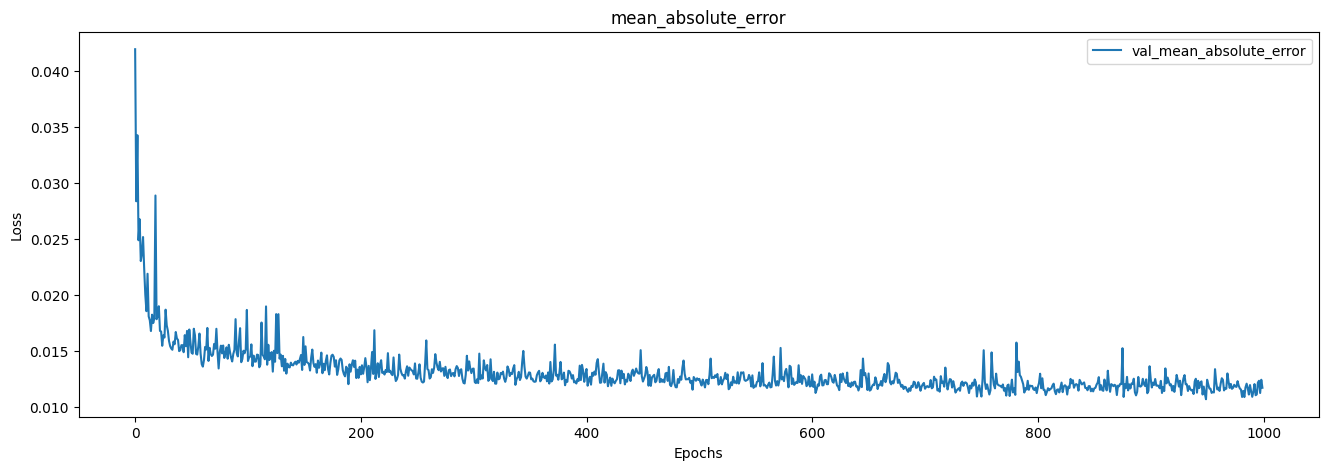

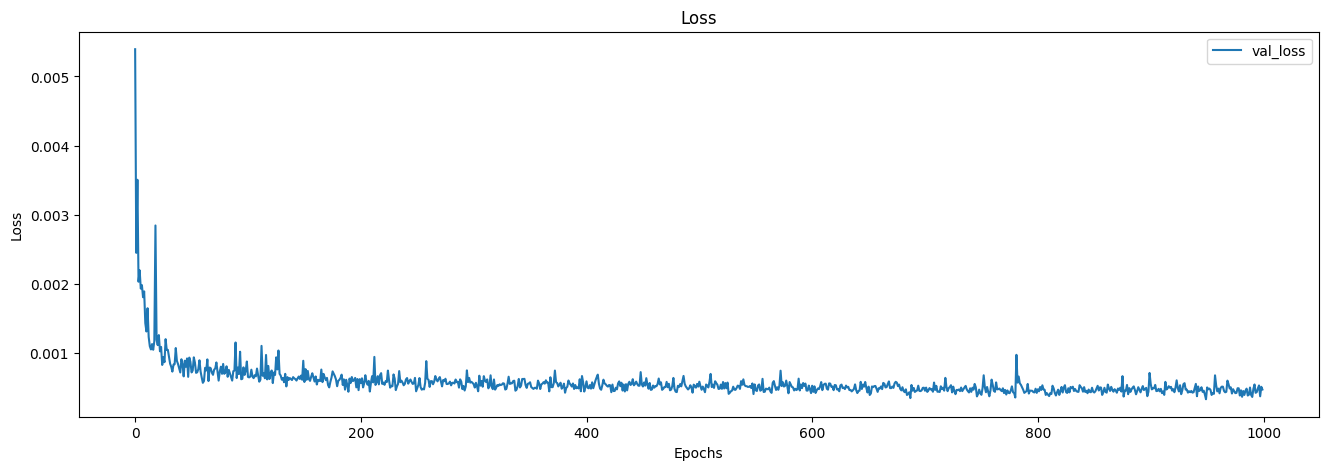

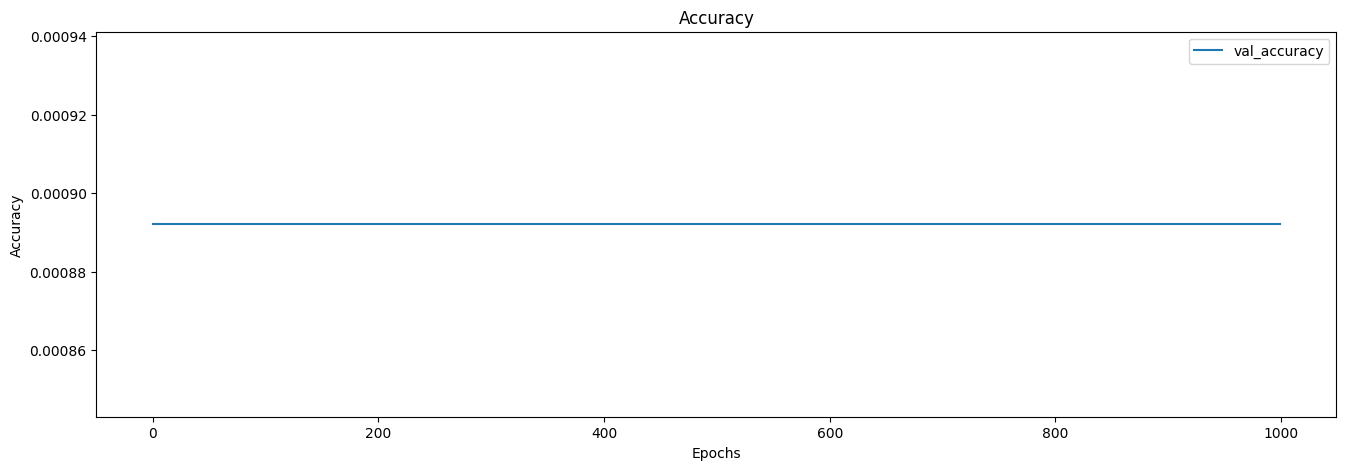

In [17]:
visualize_training_results(history)


In [18]:
# Evaluate the model on the test set
mse, accuracy, mae = model.evaluate(X_test_new, y_test_new)


18/18 [==============================] - 4s 31ms/step - loss: 0.0013 - accuracy: 0.0036 - mean_absolute_error: 0.0260


In [19]:

# Step 8: Tuning the Hyperparameters
# You can use techniques such as grid search or random search to find the best values for the model's hyperparameters

# Step 9: Testing the model
y_pred = model.predict(X_test_new)
print('y_pred', y_pred.shape)
print('y_test', y_test_new.shape)


# evaluat
mse = mean_squared_error(y_test_new, y_pred)
mae = mean_absolute_error(y_test_new, y_pred)
#mape = 100 * np.mean(np.abs((y_test_new - y_pred) / y_test_new))
rmse = np.sqrt(mean_squared_error(y_test_new, y_pred))


#print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))


18/18 [==============================] - 4s 31ms/step
y_pred (549, 1)
y_test (549, 1)
RMSE: 0.0365
MSE: 0.0013
MAE:0.0260


In [20]:

# convert to original data
y_pred = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test_new)


# evaluat
mse = mean_squared_error(y_test_new, y_pred)
mae = mean_absolute_error(y_test_new, y_pred)
mape = 100 * np.mean(np.abs((y_test_new - y_pred) / y_test_new))
rmse = np.sqrt(mean_squared_error(y_test_new, y_pred))


print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))


MAPE: 3.8042%
RMSE: 1891.6424
MSE: 3578311.0880
MAE:1348.4202


In [22]:
y_pred[0]

array([35587.336], dtype=float32)

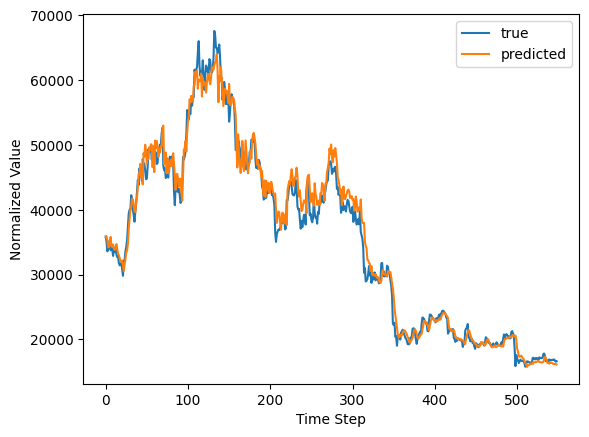

In [21]:

# plot the first sample in the test set
plt.plot(y_test_new, label='true')

# plot the corresponding predicted values
plt.plot(y_pred, label='predicted')

# set plot labels and legend
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()


In [22]:
print('y_pred',y_pred.shape)
print('y_test_new', y_test_new.shape)

y_pred (549, 1)
y_test_new (549, 1)


In [24]:
y_pred_df = pd.DataFrame(y_pred, columns=["Adj Close"])
y_test_df = pd.DataFrame(y_test_new, columns=["Adj Close"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test_new.shape[0]

# Generate dates for the next y_pred_length days

today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length+64)
test = today - timedelta(days=y_test_length+64)
prediction = pd.date_range(start=prediction_dates, end=test_data.index[-1], freq='D')
test_dates = pd.date_range(start=test, end=test_data.index[-1], freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)


In [25]:
y_test_df


,Adj Close
Date,
2021-06-30,35867.77734
2021-07-01,35040.83594
2021-07-02,33572.11719
2021-07-03,33897.04688
2021-07-04,34668.54688
...,...
2022-12-26,16841.98633
2022-12-27,16919.80469
2022-12-28,16717.17383


In [26]:
y_pred_df


,Adj Close
Date,
2021-06-30,35730.335938
2021-07-01,35919.503906
2021-07-02,35210.710938
2021-07-03,34246.257812
2021-07-04,34194.609375
...,...
2022-12-26,16219.888672
2022-12-27,16176.365234
2022-12-28,16234.591797


In [27]:

names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [29]:
# Calculate mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))


mape_value = mape(y_test_new, y_pred)
print(f'MAPE: {mape_value:.4f}%')


MAPE: 3.8042%


In [30]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


SMAPE1 = smape(y_test_new, y_pred)
print("smape: {:.4f}%".format(SMAPE1))


smape: 3.7298%


In [31]:
future_data = data.iloc[-30:, :]
future_data = future_data.values
future_data = pd.DataFrame(future_data, columns=["Open", "High", "Low", "Adj Close", "Volume", "RSI",
                                                 "EMA_short", "EMA_long"])

# Get the length of future_data
future_length = future_data.shape[0]

# Generate dates for the next 30 days
today = pd.Timestamp.now().date()
future_dates = today + timedelta(days=1)

future = pd.date_range(start=future_dates, end=today +
                       timedelta(days=30), freq='D')

# Generate dates for the next 10 days for predict
today = pd.Timestamp.now().date()
future_dates_pred = pd.date_range(start=today + timedelta(days=1), periods=10, freq='D')

# Use the generated dates as the index of the DataFrame
future_data['Date'] = future

# Set the index of the dataframes to be the 'Date' column
future_data.set_index('Date', inplace=True)

future_data.tail(10)
x_future_data = future_data.drop(['Adj Close'], axis=1).values
y_future_data = future_data['Adj Close'].values
y_future_data = y_future_data.reshape(-1, 1)

print("x_future_data:", x_future_data.shape)
print("y_future_data:", y_future_data.shape)

# x_future_data= np.reshape(x_future_data, (x_future_data.shape[0], 1, x_future_data.shape[1]))

print("x_future_data:", x_future_data.shape)
x_future_data = scaler.fit_transform(x_future_data)
y_future_data = scaler.fit_transform(y_future_data)
for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]
    # future_data_temp = future_data_temp.reshape(-1, 1)
    print("future_data_temp", future_data_temp.shape)


x_future_data: (30, 7)
y_future_data: (30, 1)
x_future_data: (30, 7)
future_data_temp (30, 7)
future_data_temp (29, 7)
future_data_temp (28, 7)
future_data_temp (27, 7)
future_data_temp (26, 7)
future_data_temp (25, 7)
future_data_temp (24, 7)
future_data_temp (23, 7)
future_data_temp (22, 7)
future_data_temp (21, 7)


In [32]:

# Initialize a numpy array to store the predictions
prediction = np.zeros((10, 1))

for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]

    print("future_data_temp1", future_data_temp.shape)
    future_data_temp = np.reshape(future_data_temp, (future_data_temp.shape[0],
                                                     1, future_data_temp.shape[1]))
    pred = model.predict(future_data_temp)
    print("future_data_temp2", future_data_temp.shape)
    print('---------------------------------------------------')
    prediction[i][0] = pred[0][0]
    x_future_data[i+future_data_temp.shape[0]-1][0] = pred[0][0]
print('3', future_data.shape)
print('prediction:', prediction.shape)
# Reverse the MinMaxScaler
y_future_data = y_future_data.reshape(-1, 1)
y_future_data = scaler.inverse_transform(y_future_data)
prediction = scaler.inverse_transform(prediction)

# Create a new dataframe with the predicted values and the dates as the index
prediction_df = pd.DataFrame(
    prediction, index=future_dates_pred, columns=['Adj Close'])
print('y_future_data', y_future_data.shape)
# Get the length of future_data

y_future_data = pd.DataFrame(y_future_data,  columns=['Adj Close'])

future_length = future_data.shape[0]
test = today - timedelta(days=future_length-1)
test_dates = pd.date_range(start=test, end=today, freq='D')
# Use the generated dates as the index of the DataFrame


y_future_data['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column

y_future_data.set_index('Date', inplace=True)


future_data_temp1 (30, 7)
1/1 [==============================] - 4s 4s/step
future_data_temp2 (30, 1, 7)
---------------------------------------------------
future_data_temp1 (29, 7)
1/1 [==============================] - 0s 43ms/step
future_data_temp2 (29, 1, 7)
---------------------------------------------------
future_data_temp1 (28, 7)
1/1 [==============================] - 0s 133ms/step
future_data_temp2 (28, 1, 7)
---------------------------------------------------
future_data_temp1 (27, 7)
1/1 [==============================] - 0s 109ms/step
future_data_temp2 (27, 1, 7)
---------------------------------------------------
future_data_temp1 (26, 7)
1/1 [==============================] - 0s 94ms/step
future_data_temp2 (26, 1, 7)
---------------------------------------------------
future_data_temp1 (25, 7)
1/1 [==============================] - 0s 109ms/step
future_data_temp2 (25, 1, 7)
---------------------------------------------------
future_data_temp1 (24, 7)
1/1 [==============

In [98]:

future_data1 = data.iloc[-90:, :]
future_data1 = future_data1.values
future_data1 = pd.DataFrame(future_data1, columns=["Open", "High", "Low", "Adj Close", "Volume", "RSI",
                                                 "EMA_short", "EMA_long"])

# Get the length of future_data
future_length = future_data1.shape[0]

# Generate dates for the next 30 days
today = pd.Timestamp.now().date()
future_dates = today + timedelta(days=1)

future = pd.date_range(start=future_dates, end=today +
                       timedelta(days=90), freq='D')

# Generate dates for the next 10 days for predict
today = pd.Timestamp.now().date()
future_dates_pred = pd.date_range(start=today + timedelta(days=1), periods=10, freq='D')

# Use the generated dates as the index of the DataFrame
future_data1['Date'] = future

# Set the index of the dataframes to be the 'Date' column
future_data1.set_index('Date', inplace=True)

x_future_data = future_data1.drop(['Adj Close'], axis=1).values
y_future_data = future_data1['Adj Close'].values
y_future_data = y_future_data.reshape(-1, 1)

print('x_future_data:',x_future_data.shape)
print(y_future_data.shape)
# create input and output arrays
num_samples = len(x_future_data) - 15
x_future_data = np.zeros((num_samples, 15, 7))
y_future_data = np.zeros((num_samples, 1))

for i in range(num_samples):
    x_future_data[i] = future_data1[i:i+15]
    y_future_data[i] = future_data1[i+15][3]  # closing price on the 16th day

# reshape to fit the model input shape
x_future_data = x_future_data.reshape(-1, 15, x_future_data.shape[-1])
y_future_data = y_future_data.reshape(-1, 1)




print('x_future_data',x_future_data.shape)
print('y_future_data',y_future_data.shape)


x_future_data: (90, 7)
(90, 1)


ValueError: could not broadcast input array from shape (15,8) into shape (15,7)

In [33]:
prediction_df


,Adj Close
2023-03-06,23567.834844
2023-03-07,23692.314296
2023-03-08,23231.673304
2023-03-09,22809.902923
2023-03-10,22946.742884
2023-03-11,22937.715151
2023-03-12,22216.180565
2023-03-13,21966.784830
2023-03-14,21915.920715
2023-03-15,21970.772697


In [34]:
y_future_data


,Adj Close
Date,
2023-02-04,23449.322266
2023-02-05,23331.847656
2023-02-06,22955.666016
2023-02-07,22760.109375
2023-02-08,23264.291016
2023-02-09,22939.398438
2023-02-10,21819.039062
2023-02-11,21651.183594
2023-02-12,21870.875000


In [35]:
names = cycle(['Predictions next 10 day', 'Actual data '])

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_future_data.index, y=y_future_data['Adj Close'], name='Actual data ',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [41]:
actual_x = y_future_data.index
actual_y = y_future_data['Adj Close']
pred_x = prediction_df.index
pred_y = prediction_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual_x, y=actual_y, name='Actual Data'))
fig.add_trace(go.Scatter(x=pred_x, y=pred_y,
              name='Predictions Data for 10 day'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='predict next 10 day '
)

fig.show()


In [43]:
names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=actual_x, y=actual_y, name='Actual Data'))

fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [33]:
# Get the last date in the data
last_date = data.index[-1]

# Generate the next 30 days of dates
prediction_dates = pd.date_range(last_date, periods=30, freq='D')[1:]

# Get the most recent sequence of prices from the test data
last_sequence = X_test[-1]

# Reshape the sequence to (1, n_timesteps, n_features)
print('last_sequence', last_sequence.shape)
# last_sequence = last_sequence.reshape((1, last_sequence.shape[1], 1))
last_sequence = np.reshape(
    last_sequence, (1, last_sequence.shape[0], last_sequence.shape[1]))
# Use the model to predict the next 30 days of prices

predicted_prices = model.predict(last_sequence)


# Extract the first element of the predicted prices
next_price = predicted_prices[0][0]

# Create an array of zeros with a shape of (29, 1)
zeros_array = np.zeros((29, 1))

# Concatenate the next price with the zeros array
predicted_prices = np.concatenate((np.array([[next_price]]), zeros_array))

# Inverse transform the predicted prices
predicted_prices = scaler.inverse_transform(predicted_prices)

# Create a range of 30 days starting from the day after the last day in the training data
# prediction_dates = pd.date_range(last_date + pd.DateOffset(days=1), periods=30, freq='D')

# Create a DataFrame of the predicted prices

predicted_prices = pd.DataFrame(predicted_prices, columns=[
                                'Adj Close'], index=pd.date_range(last_date, periods=30, freq='D'))


last_sequence (1, 7)
1/1 [==============================] - 0s 101ms/step


In [34]:
predicted_prices


,Adj Close
2023-02-17,21238.22310
2023-02-18,20688.78125
2023-02-19,20688.78125
2023-02-20,20688.78125
2023-02-21,20688.78125
2023-02-22,20688.78125
2023-02-23,20688.78125
2023-02-24,20688.78125
2023-02-25,20688.78125
2023-02-26,20688.78125


In [35]:
# Step 7: Plot the predicted values
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(
    x=data.index, y=data['Adj Close'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=predicted_prices.index,
              y=predicted_prices['Adj Close'], mode='lines', name='Predicted'))
fig.update_layout(title='Bitcoin Price Predictions',
                  xaxis_title='Date', yaxis_title='Price (USD)')
fig.show()


In [36]:
# Use the model to predict the next 10 days of Bitcoin prices
last_five_days = X_test[-30:]
print("last_five_days", last_five_days.shape)
last_five_days = np.reshape(
    last_five_days, (last_five_days.shape[0], 1, last_five_days.shape[2]))
predictions = []
for i in range(10):
    prediction = model.predict(last_five_days)[0]
    predictions.append(prediction)
    last_five_days = np.append(last_five_days[:, 1:, :],  [
                               prediction[np.newaxis, :]], axis=1)


last_five_days (30, 1, 7)
1/1 [==============================] - 0s 84ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 30 and the array at index 1 has size 1

In [50]:
# Use the model to predict the next 10 days of Bitcoin prices
last_five_days = np.array(X_test[-30:])
predictions = []
for i in range(10):
    """""
    print(f"last_five_days.shape={last_five_days.shape}")
    prediction = model.predict(last_five_days)[0]
    print(f"prediction.shape={prediction.shape}")
    #prediction = np.squeeze(prediction, axis=0)
    #print(f"prediction.shape={prediction.shape}")
    predictions.append(prediction)
    last_five_days = np.append(last_five_days[:,1:,:], [prediction[np.newaxis,:]], axis=1)"""

    prediction = model.predict(last_five_days)
    print(f"prediction.shape1={prediction.shape}")
    prediction = np.reshape(prediction, (prediction.shape[0], 1))
    print(f"prediction.shape2={prediction.shape}")
    predictions.append(prediction)
    prediction = np.expand_dims(prediction, axis=1)
    last_five_days = np.append(last_five_days[:, 1:, :], prediction, axis=1)


1/1 [==============================] - 0s 223ms/step
prediction.shape1=(30, 1)
prediction.shape2=(30, 1)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 7 and the array at index 1 has size 1

In [51]:
# Initialize empty list to store predictions
predictions = []

# Iterate over test data
for i in range(len(X_test) - 1):

    # Get the last 5 days of data
    last_five_days = X_test[i:i+1]

    # Reshape last_five_days to match input shape of the model
    last_five_days = np.reshape(last_five_days, (1, 1, 7))

    # Make a prediction
    prediction = model.predict(last_five_days)

    # Append prediction to list of predictions
    predictions.append(prediction)

    # Reshape prediction to match output shape of model
    prediction = np.reshape(prediction, (1, 1, 1))

    # Append prediction to last_five_days
    last_five_days = np.append(last_five_days[:, 1:, :], prediction, axis=1)


1/1 [==============================] - 0s 116ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 7 and the array at index 1 has size 1

In [66]:
# Generate predictions
predictions = []
for i in range(len(X_test)):
    X_test = last_five_days.reshape((1, 1, 7))
    prediction = model.predict(X_test, verbose=1)
    predictions.append(prediction)
    prediction = np.reshape(prediction, (1, 1, 1))
    print('1- prediction     :', prediction.shape)
    print('2- last_five_days :', last_five_days.shape)
    last_five_days = np.append(last_five_days[:, 1:, :], prediction, axis=2)

# Convert predictions to array and reshape
predictions = np.array(predictions).reshape(-1, 1)


1/1 [==============================] - 0s 102ms/step
1- prediction     : (1, 1, 1)
2- last_five_days : (1, 1, 7)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 1